In [27]:
# load in the data

import numpy as np
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot
airline = pd.read_csv('/Users/williamalston/teaching/coding/airline_passengers.csv', index_col='Month',parse_dates=True)

#airline.index.freq = 'MS'
#airline.head()
airline.index



DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [5]:
#simple moving average
#use rolling(window=6).mean()

# 6 month SMA
airline['6-month-SMA'] = airline['Passengers'].rolling(window=6).mean()

# 12 month SMA
airline['12-month-SMA'] = airline['Passengers'].rolling(window=12).mean()

bool_series = airline.duplicated()



<AxesSubplot:title={'center':'Simple Moving Averages'}, xlabel='Month'>

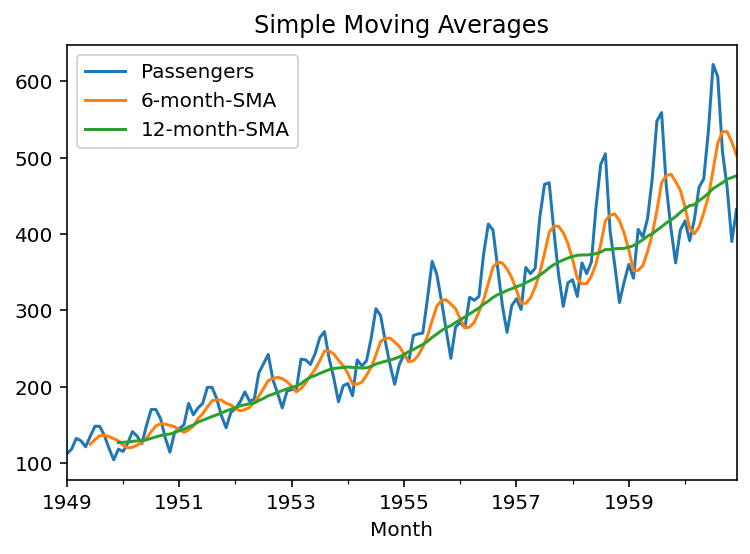

In [6]:
fig, ax = pyplot.subplots(dpi=144)

airline.plot(title='Simple Moving Averages', ax=ax)

In [9]:
from statsmodels.tsa.filters.hp_filter import hpfilter
#remaining, trend = hpfilter(airline, lamb=6.25) 
    # for Annual Data lambda is 6.25

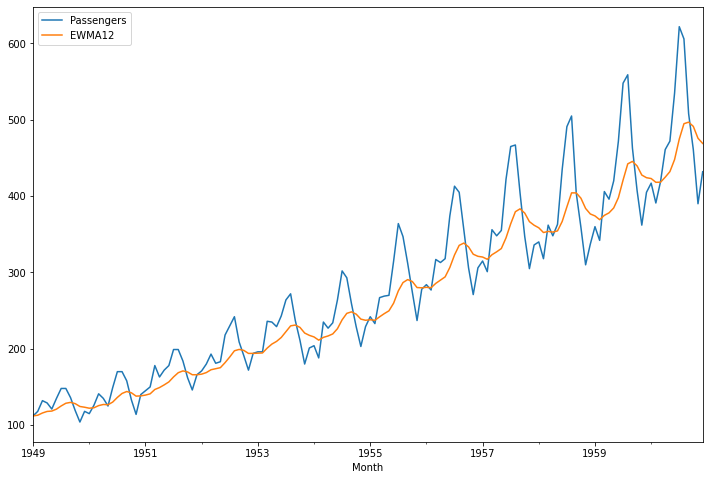

In [16]:
airline['EWMA12'] = airline['Passengers'].ewm(span=12,adjust=False).mean()
# Alpha value is calculated based on time interval (span)
# span = 12, alpha = 2/(span+1)
airline[['Passengers','EWMA12']].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

In [13]:
df = pd.DataFrame({'B': [0, 1, 2, 3, 4]})

df.ewm(com=0.5).mean()

,B
0,0.000000
1,0.750000
2,1.615385
3,2.550000
4,3.520661


# Forecasting

In [19]:
# Split data into training and testing data

# all but last 12 months as training data
train_data = airline.iloc[:-12]
# Last 12 Months as Test Data
test_data = airline.iloc[-12:]

In [20]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(train_data['Passengers'],
                              trend='add',
                              seasonal='mul',
                              seasonal_periods=12)
fitted_model = model.fit()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


In [21]:
fitted_model.summary()

Dep. Variable:,endog,No. Observations:,132
Model:,ExponentialSmoothing,SSE,13420.400
Optimized:,True,AIC,642.068
Trend:,Additive,BIC,688.193
Seasonal:,Multiplicative,AICC,648.121
Seasonal Periods:,12,Date:,"Sun, 12 Feb 2023"
Box-Cox:,False,Time:,18:19:57
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3157895,alpha,True
smoothing_slope,0.0526313,beta,True


## Predictions

Create an out of sample forecast for the next 12 steps beyond the final data point in the training data set.

In [22]:
test_predictions = fitted_model.forecast(12).rename('HW Forecast')

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:xlabel='Month'>

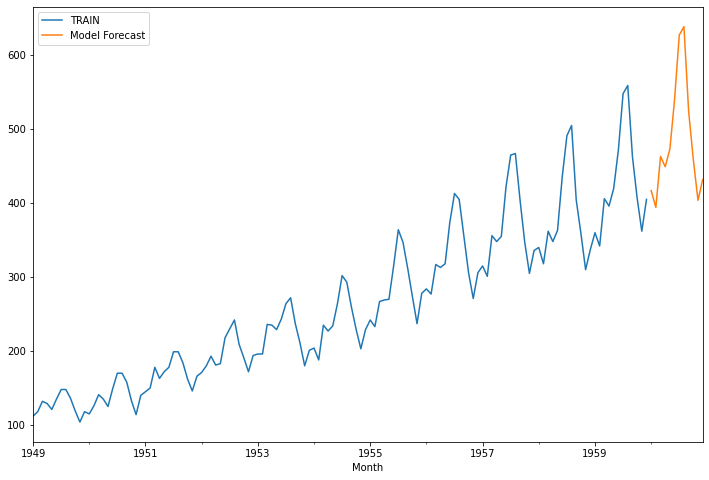

In [37]:
#plot


train_data['Passengers'].plot(legend=True,label='TRAIN')
test_predictions.plot(legend=True,label='Model Forecast',figsize=(12,8))

## add back in real values to see how they compare

<AxesSubplot:xlabel='Month'>

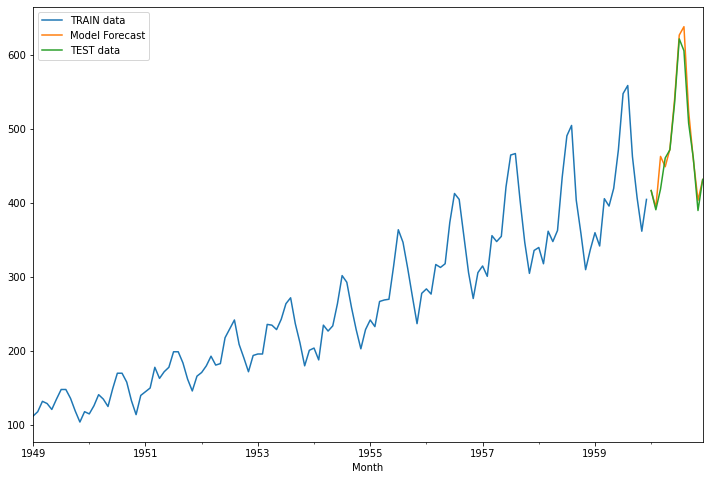

In [39]:
train_data['Passengers'].plot(legend=True,label='TRAIN data')
test_predictions.plot(legend=True,label='Model Forecast')
test_data['Passengers'].plot(legend=True,label='TEST data',figsize=(12,8))


In [35]:
#Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error

a = mean_absolute_error(test_data['Passengers'],test_predictions)

b = mean_squared_error(test_data['Passengers'], test_predictions)



In [36]:
airline.describe()


,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000
